# Text to Image - Diffusion 12M

### Given any text prompt, the model generates the coressponding image.

This colab is a refactored version of [this one](https://colab.research.google.com/drive/1TBo4saFn1BCSfgXsmREFrUl3zSQFg6CC).

Original Author: [Katherine Crowson](https://github.com/crowsonkb)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/crowsonkb/v-diffusion-pytorch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/TextToImageDiffusion12M.ipynb)

In [ ]:
#@title Setup

!pip install ftfy regex requests tqdm
!git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch
!mkdir v-diffusion-pytorch/checkpoints
!curl -L https://v-diffusion.s3.us-west-2.amazonaws.com/cc12m_1_cfg.pth > v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth

import gc
import math
import sys

from IPython import display
import torch
from torchvision import utils as tv_utils
from torchvision.transforms import functional as TF
from tqdm.notebook import trange, tqdm

sys.path.append('/content/v-diffusion-pytorch')

from CLIP import clip
from diffusion import get_model, sampling, utils

model = get_model('cc12m_1_cfg')()
_, side_y, side_x = model.shape
model.load_state_dict(torch.load('v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth', map_location='cpu'))
model = model.half().cuda().eval().requires_grad_(False)
clip_model = clip.load(model.clip_model, jit=False, device='cpu')[0]

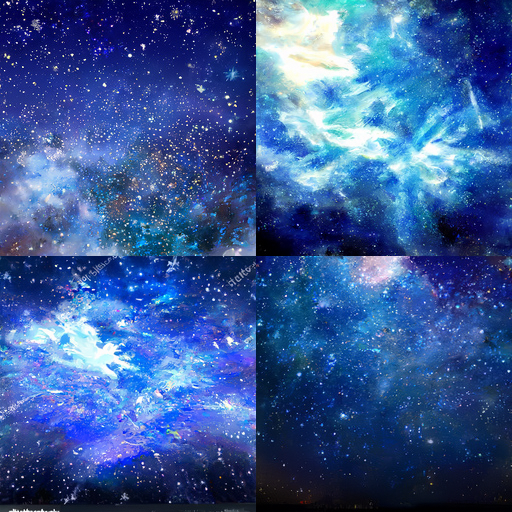

In [11]:
#@title Run

#@markdown The text prompt
prompt = 'Stars full of sky in Taipei, fantasy water painting style.'  #@param {type:"string"}

#@markdown The strength of the text conditioning (0 means don't condition on text, 1 means sample images that match the text about as well as the images match the text captions in the training set, 3+ is recommended).
weight = 5  #@param {type:"number"}

#@markdown Sample this many images.
n_images = 4  #@param {type:"integer"}

#@markdown Specify the number of diffusion timesteps (default is 50, can lower for faster but lower quality sampling).
steps = 50  #@param {type:"integer"}

#@markdown The random seed. Change this to sample different images.
seed = 0  #@param {type:"integer"}

#@markdown Display progress every this many timesteps.
display_every = 10  #@param {type:"integer"}

target_embed = clip_model.encode_text(clip.tokenize(prompt)).float().cuda()


def cfg_model_fn(x, t):
    """The CFG wrapper function."""
    n = x.shape[0]
    x_in = x.repeat([2, 1, 1, 1])
    t_in = t.repeat([2])
    clip_embed_repeat = target_embed.repeat([n, 1])
    clip_embed_in = torch.cat([torch.zeros_like(clip_embed_repeat), clip_embed_repeat])
    v_uncond, v_cond = model(x_in, t_in, clip_embed_in).chunk(2, dim=0)
    v = v_uncond + (v_cond - v_uncond) * weight
    return v


def display_callback(info):
    if info['i'] % display_every == 0:
        nrow = math.ceil(info['pred'].shape[0]**0.5)
        grid = tv_utils.make_grid(info['pred'], nrow, padding=0)
        tqdm.write(f'Step {info["i"]} of {steps}:')
        display.display(utils.to_pil_image(grid))
        tqdm.write(f'')


def run():
    gc.collect()
    torch.cuda.empty_cache()
    torch.manual_seed(seed)
    x = torch.randn([n_images, 3, side_y, side_x], device='cuda')
    t = torch.linspace(1, 0, steps + 1, device='cuda')[:-1]
    step_list = utils.get_spliced_ddpm_cosine_schedule(t)
    outs = sampling.plms_sample(cfg_model_fn, x, step_list, {}, callback=display_callback)
    tqdm.write('Done!')
    for i, out in enumerate(outs):
        filename = f'out_{i}.png'
        utils.to_pil_image(out).save(filename)
        display.display(display.Image(filename))


run()